Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside the course repo
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [4]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy


## The *Nim* and *Nimply* classes

In [5]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [6]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies

In [7]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [8]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [9]:
def adaptive_strategy(genome):
    def adaptive(state: Nim) -> Nimply:
        analysis = analize(state)
        possible_moves = analysis['possible_moves']

        # Calcola il valore target di nim_sum basato su "target_preference"
        range_span = max(possible_moves.values()) - min(possible_moves.values())
        target_nim_sum = genome["target_preference"] * range_span + min(possible_moves.values())

        # Trova la mossa con il nim_sum più vicino al valore target
        closest_move = min(possible_moves.items(),
                           key=lambda x: abs(x[1] - target_nim_sum))

        # Controlla se c'è una mossa all'interno dell'intervallo di tolleranza
        tolerance = 0.05 * range_span
        moves_in_range = [move for move, nim_sum in possible_moves.items()
                          if (target_nim_sum - tolerance) <= nim_sum <= (target_nim_sum + tolerance)]

        if moves_in_range:
            chosen_move = random.choice(moves_in_range)
        else:
            chosen_move = closest_move[0]  # scegli la mossa più vicina se non ci sono mosse nell'intervallo

        return chosen_move

    return adaptive


In [11]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [ ]:
logging.getLogger().setLevel(logging.INFO)

genome={"target_preference":0.5}
adaptive = adaptive_strategy(genome)
strategy = (adaptive, optimal)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


# Real match

# Genome

The genome is made of 2 parts: `target_preference` e `target_range`.
- The `target_preference` in the genome indicates an individual's bias towards a desired nim_sum outcome within the possible range of the game state, scaled as a float between 0 and 1 to match the full span of potential `nim_sum` values in Nim.
- The `target_range` in the genome defines the proportion of the total `nim_sum` range that an individual is willing to consider as acceptable for making a move, with the value being a float between 0 and 1 to represent the size of this acceptable subset relative to the game's full range of nim_sum possibilities.

In [13]:
def generate_random_genome():
    return {
        "target_preference": random.random(),  # A random value dictating preferred nim_sum target
        "target_range": random.random(),       # A random value indicating the acceptable range span
        "fitness": 0                           # Initial fitness value, to be updated during simulation
    }


# Adaptive Function
The `adaptive_strategy` function generates a closure that embodies an adaptive strategy for playing the game of Nim, based on the genome's traits. It calculates a target `nim_sum` based on the genome's `target_preference`, and defines an acceptable range of `nim_sum` values around this target using the `target_range`. The strategy then selects a move within this acceptable range if possible; if not, it picks a move at random. This adaptive approach allows for dynamic decision-making that evolves as the game progresses

In [14]:
def adaptive_strategy(genome):
    def adaptive(state: Nim) -> Nimply:
        analysis = analize(state)
        possible_moves = analysis['possible_moves']

        # Calculate the target nim_sum based on "target_preference"
        range_span = max(possible_moves.values()) - min(possible_moves.values())
        target_nim_sum = genome["target_preference"] * range_span + min(possible_moves.values())

        # Define the acceptable range of nim_sum based on "target_range"
        acceptable_range_span = genome["target_range"] * range_span
        lower_bound = target_nim_sum - acceptable_range_span / 2
        upper_bound = target_nim_sum + acceptable_range_span / 2

        # Find the moves within the acceptable range of nim_sum
        moves_in_range = [move for move, nim_sum in possible_moves.items()
                          if lower_bound <= nim_sum <= upper_bound]

        # If there are moves within the acceptable range, choose one at random
        if moves_in_range:
            chosen_move = random.choice(moves_in_range)
        else:
            # If no moves are within the acceptable range, choose a move at random
            chosen_move = random.choice(list(possible_moves.keys()))

        return chosen_move

    return adaptive


# Parent selection
The `tournament_selection` function is a selection mechanism in genetic algorithms that picks the fittest individual from a randomly chosen subset of the population. It simulates a tournament where a group of individuals, determined by the `tournament_size`, competes based on their fitness values. The individual with the highest `fitness` within this group is declared the winner and is selected for breeding in the next generation of the population.

In [15]:
def tournament_selection(population, tournament_size):
    tournament_participants = random.sample(list(population), tournament_size)
    winner = max(tournament_participants, key=lambda x: x['fitness'])
    return winner

The `roulette_wheel_selection` function in genetic algorithms selects an individual from a population based on their fitness. Each individual's chance of being chosen is proportional to their fitness relative to the total fitness of the population. The selection is made by generating a random number and picking the individual whose cumulative fitness matches or exceeds this number.

In [36]:
def roulette_wheel_selection(population):
    # Calculate the total fitness of the population
    total_fitness = sum(individual['fitness'] for individual in population)

    # Generate a random number between 0 and the total fitness
    spin = random.uniform(0, total_fitness)

    # Start summing the fitness of individuals until it reaches or exceeds the random number
    running_sum = 0
    for individual in population:
        running_sum += individual['fitness']
        if running_sum >= spin:
            # Return the individual whose cumulative fitness reaches/exceeds the random number
            return individual

    # In case of rounding error, return the last individual
    return population[-1]


# Crossover
The `crossover` function combines the genetic traits of two parent genomes to produce a child genome, taking into account the parents' `target_preference` and `target_range` values, weighted by their respective `fitness`. It introduces variability through a random factor, ensuring diversity in the offspring, with the child's initial `fitness` set to zero.

In [16]:
def crossover(parent1, parent2):
    total_fitness = parent1["fitness"] + parent2["fitness"]
    bias = parent1["fitness"] / total_fitness if total_fitness > 0 else 0.5

    # Crossover for target_preference
    crossover_point_pref = bias * parent1["target_preference"] + (1 - bias) * parent2["target_preference"]
    variation_pref = random.uniform(-0.1, 0.1) * abs(parent1["target_preference"] - parent2["target_preference"])
    new_preference_value = crossover_point_pref + variation_pref
    new_preference_value = min(max(new_preference_value, 0), 1)

    # Crossover for target_range
    crossover_point_range = bias * parent1["target_range"] + (1 - bias) * parent2["target_range"]
    variation_range = random.uniform(-0.1, 0.1) * abs(parent1["target_range"] - parent2["target_range"])
    new_range_value = crossover_point_range + variation_range
    new_range_value = min(max(new_range_value, 0), 1)

    # Create a child with the new target_preference and target_range
    child = {
        "target_preference": new_preference_value,
        "target_range": new_range_value,
        "fitness": 0
    }

    return child


# Mutation
The `mutate` function introduces random variations to a genome's `target_preference` and `target_range` attributes based on a specified mutation rate, potentially altering an individual's strategy for the game of Nim.

In [17]:
def mutate(genome, mutation_rate):
    # Mutate target_preference
    if random.random() < mutation_rate:
        genome["target_preference"] = random.random()  # Assign a new random value
    
    # Mutate target_range with the same mutation rate
    if random.random() < mutation_rate:
        genome["target_range"] = random.random()  # Assign a new random value for target_range as well

    return genome

# Generate Population
The `generate_new_population` function creates a new generation of individuals for the evolutionary algorithm. It repeatedly selects pairs of parent genomes from the selected parents, performs crossover to produce a child, applies mutations to this child, and then adds the child to the new population. This process continues until the new population reaches the desired number of individuals.

In [18]:
def generate_new_population(selected_parents, n_individuals, mutation_rate):
    new_population = []
    while len(new_population) < n_individuals:
        # Randomly select two parents for crossover
        parent1, parent2 = random.sample(selected_parents, 2)
        # Generate a child through crossover of the two parents
        child1 = crossover(parent1, parent2)
        # Apply mutation to the child
        child1 = mutate(child1, mutation_rate)
        # Add the mutated child to the new population
        new_population.append(child1)
    # Return the new population, sliced to the number of desired individuals
    return new_population[:n_individuals]


# Simulation 

In [19]:
def play_nim_game(strategy1, strategy2, initial_nim_state):
    nim = initial_nim_state
    player = 0
    while nim:
        ply = strategy1(nim) if player == 0 else strategy2(nim)
        nim.nimming(ply)
        player = 1 - player
    return player

In [39]:
def simulation(n_epochs = 10, n_games=10, n_individuals=100, n_parents=50, tournament_size = 10, mutation_rate = 0.1, parent_selection = "tournament"):
  # Generate random population
  population = np.array([[generate_random_genome() for _ in range(n_individuals)]])
  # Start simulation
  for epoch in range(n_epochs):
    #for each individual play x games
    for individual in population[epoch]:
      for _ in range(n_games):
        adaptive = adaptive_strategy(individual)
        strategy = (adaptive, optimal)
        winner = play_nim_game(strategy[0], strategy[1], Nim(5))
        # Update fitness if the indivisual wins
        if winner == 0:
          individual["fitness"] +=1
    #print(population[epoch])
    selected_parents = []
    # Select x parent for the new population
    for _ in range(n_parents):
      if parent_selection == "roulette":
        selected_parents.append(roulette_wheel_selection(population[epoch]))
      else:
        selected_parents.append(tournament_selection(population[epoch], tournament_size))

    new_population = generate_new_population(selected_parents, n_individuals, mutation_rate)

    population=np.append(population, [new_population], axis=0)
    #print(epoch)
  return population

In [40]:
pop_r = simulation(n_epochs = 10, n_games=25, n_individuals=200, n_parents=100, mutation_rate = 0.1, parent_selection = "roulette")

In [41]:
pop_t = simulation(n_epochs = 10, n_games=25, n_individuals=200, n_parents=100, tournament_size = 50, mutation_rate = 0.1, parent_selection = "tournament")

# Plot functions

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_comparison(array, name = "tournament"):
    # Assuming 'array' is of shape (n_epochs, n_individuals)
    # and each element of 'array' is a dictionary containing 'target_preference' and 'target_range'

    # Set up the figure and axes
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Plot for target_preference
    for epoch_index, epoch in enumerate(array):
        preferences = [individual["target_preference"] for individual in epoch]
        axes[0].scatter(preferences, [epoch_index + 1]*len(epoch), alpha=0.5, label=f'Epoch {epoch_index + 1}')

    axes[0].set_title(f'Scatter Comparison of Target Preferences Across Epochs, {name} selection')
    axes[0].set_xlabel('Target Preference')
    axes[0].set_xticks(np.arange(0, 1, 0.1))
    axes[0].set_ylabel('Epoch')
    axes[0].set_yticks(np.arange(1, len(array) + 1))
    axes[0].legend()

    # Plot for target_range
    for epoch_index, epoch in enumerate(array):
        ranges = [individual["target_range"] for individual in epoch]
        axes[1].scatter(ranges, [epoch_index + 1]*len(epoch), alpha=0.5, label=f'Epoch {epoch_index + 1}')

    axes[1].set_title(f'Scatter Comparison of Target Ranges Across Epochs, {name} selection')
    axes[1].set_xlabel('Target Range')
    axes[1].set_xticks(np.arange(0, 1, 0.1))
    axes[1].set_ylabel('Epoch')
    axes[1].set_yticks(np.arange(1, len(array) + 1))
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'./scatter_{name}.png')

    # Show the plots
    plt.show()


In [63]:
from matplotlib.animation import FuncAnimation

def update_heatmap(frame, populations, preference_bins, range_bins, wins_bins, im_preference, im_range, max_count_preference, max_count_range, text1, text2):
    # Populate the matrix for the current frame (epoch) for target_preference
    heatmap_matrix_preference = np.zeros((len(wins_bins), len(preference_bins)))
    heatmap_matrix_range = np.zeros((len(wins_bins), len(range_bins)))  # For target_range
    
    for individual in populations[frame]:
        preference_index = np.digitize(individual["target_preference"], preference_bins) - 1
        range_index = np.digitize(individual["target_range"], range_bins) - 1  # For target_range
        wins_index = np.digitize(individual["fitness"], wins_bins) - 1
        
        heatmap_matrix_preference[wins_index, preference_index] += 1
        heatmap_matrix_range[wins_index, range_index] += 1  # For target_range
    
    # Update the heatmap for target_preference
    im_preference.set_array(heatmap_matrix_preference)
    im_preference.set_clim(0, max_count_preference)  # Adjust colormap limits to reflect the new maximum
    
    # Update the heatmap for target_range
    im_range.set_array(heatmap_matrix_range)
    im_range.set_clim(0, max_count_range)  # Adjust colormap limits to reflect the new maximum
    
    text1.set_text(f'Epoch: {frame + 1}')
    text2.set_text(f'Epoch: {frame + 1}')
    
    return [im_preference, im_range, text1, text2]

def plot_heatmap_animation(populations, num_games, bin_size=0.1, name = "tournament"):
    # Set ranges for target_preference and target_range
    preference_bins = np.arange(0, 1 + bin_size, bin_size)
    range_bins = np.arange(0, 1 + bin_size, bin_size)  # For target_range
    wins_bins = np.arange(0, num_games + 1, 1)

    # Calculate the maximum value for the colormap
    #max_count = max(len(epoch) for epoch in populations)
    # Calcola il valore massimo raggiunto in qualsiasi cella attraverso tutte le epoche
    # Calcola il valore massimo di individui per ogni bin di 'target_preference' e 'target_range' nelle varie epoche
    max_count_preference = np.max([
        np.histogram(
            [individual["fitness"] for individual in epoch if individual["target_preference"] >= pref_bin and individual["target_preference"] < pref_bin + bin_size],
            bins=wins_bins
        )[0]
        for pref_bin in preference_bins[:-1]
        for epoch in populations
    ])
    
    max_count_range = np.max([
        np.histogram(
            [individual["fitness"] for individual in epoch if individual["target_range"] >= range_bin and individual["target_range"] < range_bin + bin_size],
            bins=wins_bins
        )[0]
        for range_bin in range_bins[:-1]
        for epoch in populations
    ])
    
    

    # Initialize the matrix for the heatmap
    heatmap_matrix_preference = np.zeros((len(wins_bins)-1, len(preference_bins)-1))
    heatmap_matrix_range = np.zeros((len(wins_bins)-1, len(range_bins)-1))  # For target_range

    # Create the figure and axes for the animation
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))  # Two subplots
    text1 = ax1.text(0.02, 0.95, '', transform=ax1.transAxes, color='white')
    text2 = ax2.text(0.02, 0.95, '', transform=ax2.transAxes, color='white')

    # Create the first image of the heatmap for target_preference
    im_preference = ax1.imshow(heatmap_matrix_preference, cmap='hot', interpolation='nearest', aspect='auto')
    ax1.set_xlabel('Target Preference Range')
    ax1.set_ylabel('Number of Wins')
    ax1.set_title(f'Heatmap of Wins by Target Preference epoch')

    # Create the first image of the heatmap for target_range
    im_range = ax2.imshow(heatmap_matrix_range, cmap='hot', interpolation='nearest', aspect='auto')
    ax2.set_xlabel('Target Range Range')
    ax2.set_ylabel('Number of Wins')
    ax2.set_title('Heatmap of Wins by Target Range')

    # Set the tick marks for axes
    # Code for setting ticks goes here...

    # Colorbar to interpret the heat values
    plt.colorbar(im_preference, ax=ax1)
    plt.colorbar(im_range, ax=ax2)

    # Create the animation
    anim = FuncAnimation(fig, update_heatmap, frames=len(populations), fargs=(populations, preference_bins, range_bins, wins_bins, im_preference, im_range, max_count_preference, max_count_range, text1, text2), blit=True)

    # Show the animation
    plt.tight_layout()  # Adjust layout to prevent overlap
    anim.save(f'animation_{name}.gif', writer='imagemagick', fps=1)
    # plt.show()
    return anim

# Assuming 'populations' is a NumPy array of shape (n_epochs, n_individuals)
# plot_heatmap_animation(populations[0:-1], num_games=30)


In [64]:
from matplotlib.animation import FuncAnimation
def update_heatmap_single(frame, populations, bin_size, preference_bins, range_bins, im, max_count, text):
    # Reset the heatmap matrix for the current frame (epoch)
    heatmap_matrix = np.zeros((len(range_bins)-1, len(preference_bins)-1))

    # Populate the matrix with the sum of fitness for each combination of target_preference and target_range
    for individual in populations[frame]:
        preference_index = np.digitize(individual["target_preference"], preference_bins) - 1
        range_index = np.digitize(individual["target_range"], range_bins) - 1
        heatmap_matrix[range_index, preference_index] += individual["fitness"]

    # Update the heatmap
    im.set_array(heatmap_matrix)
    #im.set_clim(0, np.max(heatmap_matrix))  # Set the scale of the colormap to a fixed maximum for consistency
    im.set_clim(0, max_count)  # Set the scale of the colormap to a fixed maximum for consistency
    
    text.set_text(f'Epoch: {frame + 1}')
    
    return [im, text]

def plot_heatmap_animation_single(populations, bin_size=0.1, name = "tournament"):
    # Set ranges for target_preference and target_range
    preference_bins = np.arange(0, 1 + bin_size, bin_size)
    range_bins = np.arange(0, 1 + bin_size, bin_size)

    # Calculate the maximum value for the colormap across all frames
    #max_count = np.max([np.sum([individual["fitness"] for individual in epoch]) for epoch in populations])
    
    # Calculate the maximum fitness value achieved in any bin across all epochs
    max_count = np.max([
        np.max([
            np.sum([
                individual["fitness"] for individual in epoch 
                if np.digitize(individual["target_preference"], preference_bins) - 1 == preference_index and
                   np.digitize(individual["target_range"], range_bins) - 1 == range_index
            ])
            for preference_index in range(len(preference_bins)-1)
            for range_index in range(len(range_bins)-1)
        ])
        for epoch in populations
    ])
    

    # Create the figure and axis for the animation
    fig, ax = plt.subplots(figsize=(12, 7))

    # Initialize the heatmap matrix
    heatmap_matrix = np.zeros((len(range_bins)-1, len(preference_bins)-1))

    # Create the initial image of the heatmap
    im = ax.imshow(heatmap_matrix, cmap='hot', interpolation='nearest', aspect='auto', origin='lower')
    text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color='white')

    # Set labels for the axes
    ax.set_xlabel('Target Preference')
    ax.set_ylabel('Target Range')
    ax.set_title(f'Animated Heatmap of Fitness by Target Preference and Target Range, {name} selection')

    # Set tick marks for the axes
    ax.set_xticks(np.arange(len(preference_bins)-1))
    ax.set_xticklabels(['{:.1f}'.format((preference_bins[i] + preference_bins[i+1]) / 2) for i in range(len(preference_bins)-1)])
    ax.set_yticks(np.arange(len(range_bins)-1))
    ax.set_yticklabels(['{:.1f}'.format((range_bins[i] + range_bins[i+1]) / 2) for i in range(len(range_bins)-1)])

    # Add a color bar to interpret the heatmap values
    plt.colorbar(im, ax=ax)

    # Create the animation
    anim = FuncAnimation(fig, update_heatmap_single, frames=len(populations), fargs=(populations, bin_size, preference_bins, range_bins, im, max_count, text), blit=True)

    # Show the animation
    plt.tight_layout()
    anim.save(f'animation_single_{name}.gif', writer='imagemagick', fps=1)
    # plt.show()
    return anim

# Assuming 'populations' is a list of numpy arrays of shape (n_individuals) for each epoch
# plot_heatmap_animation(populations)


In [65]:
import matplotlib.pyplot as plt

def plot_wins_over_epochs(populations, name = "tournament"):
    total_wins_per_epoch = [sum(individual["fitness"] for individual in epoch) for epoch in populations]
    plt.figure(figsize=(10, 6))
    plt.plot(total_wins_per_epoch, marker='o')  
    plt.title(f'Total Wins Over Epochs, {name} selection')
    plt.xlabel('Epoch')
    plt.ylabel('Total Wins')
    plt.savefig(f'./wins_{name}.png')
    plt.show()


# Results

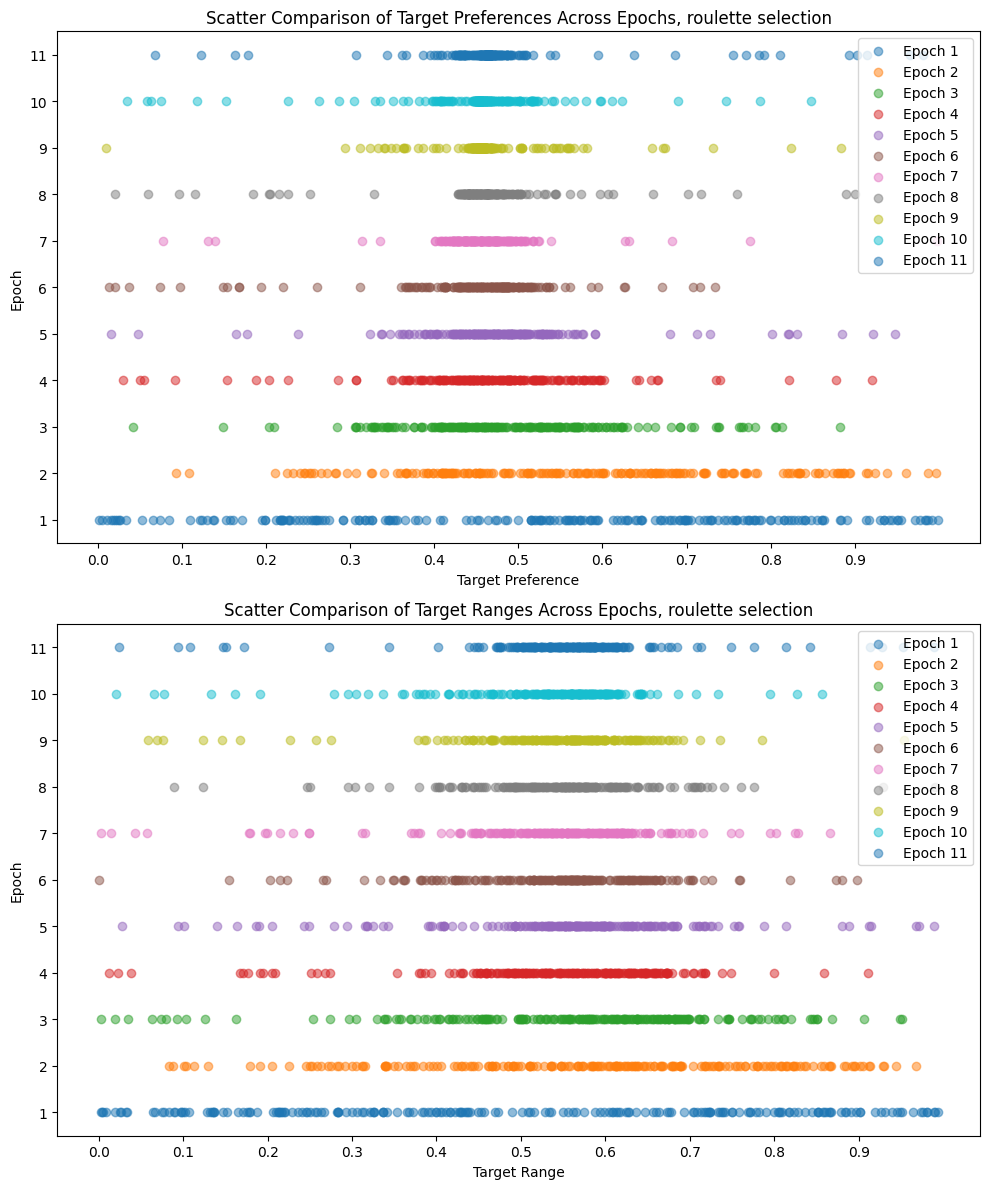

In [66]:
plot_scatter_comparison(pop_r, name = "roulette")

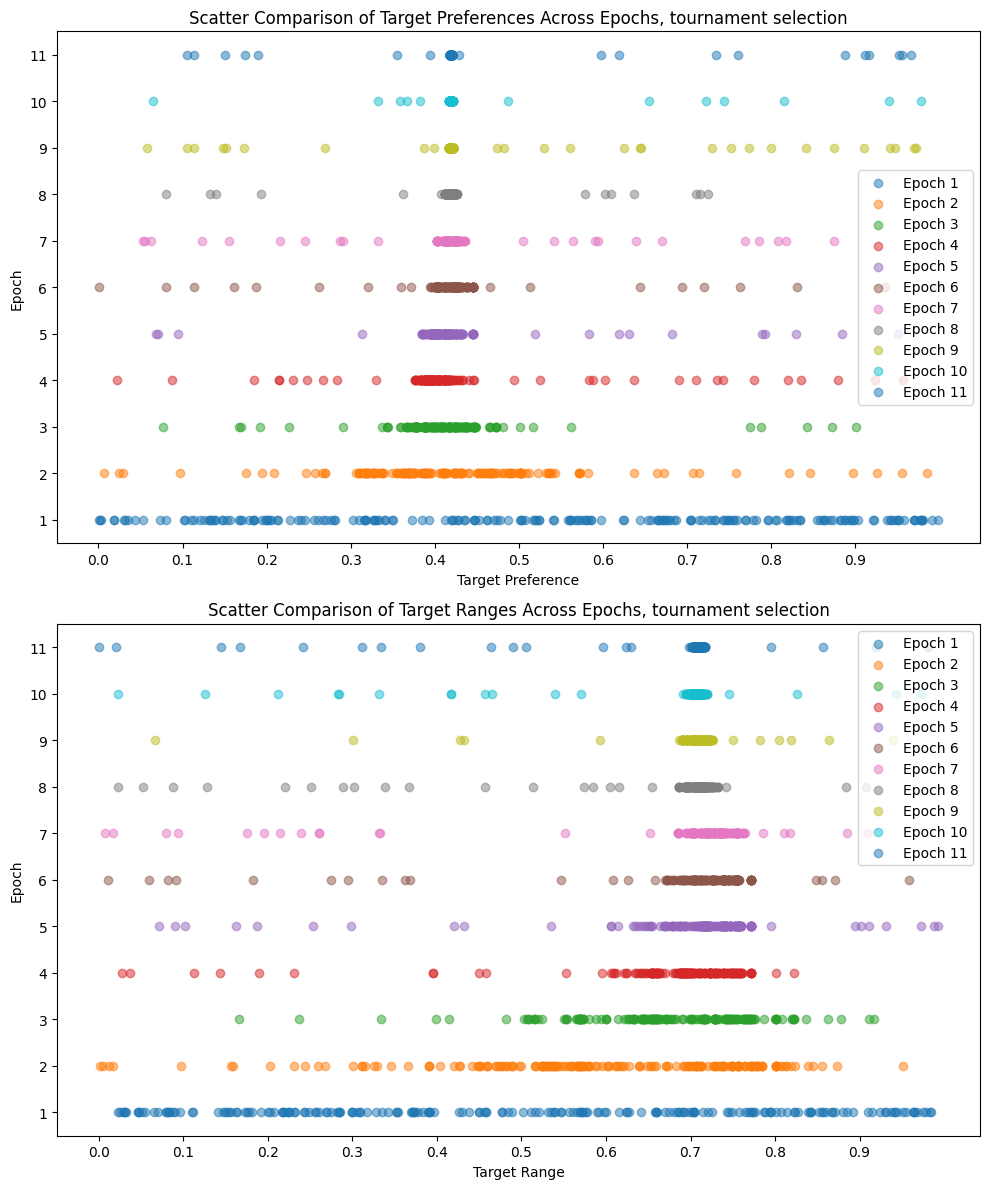

In [67]:
plot_scatter_comparison(pop_t, name = "tournament")

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


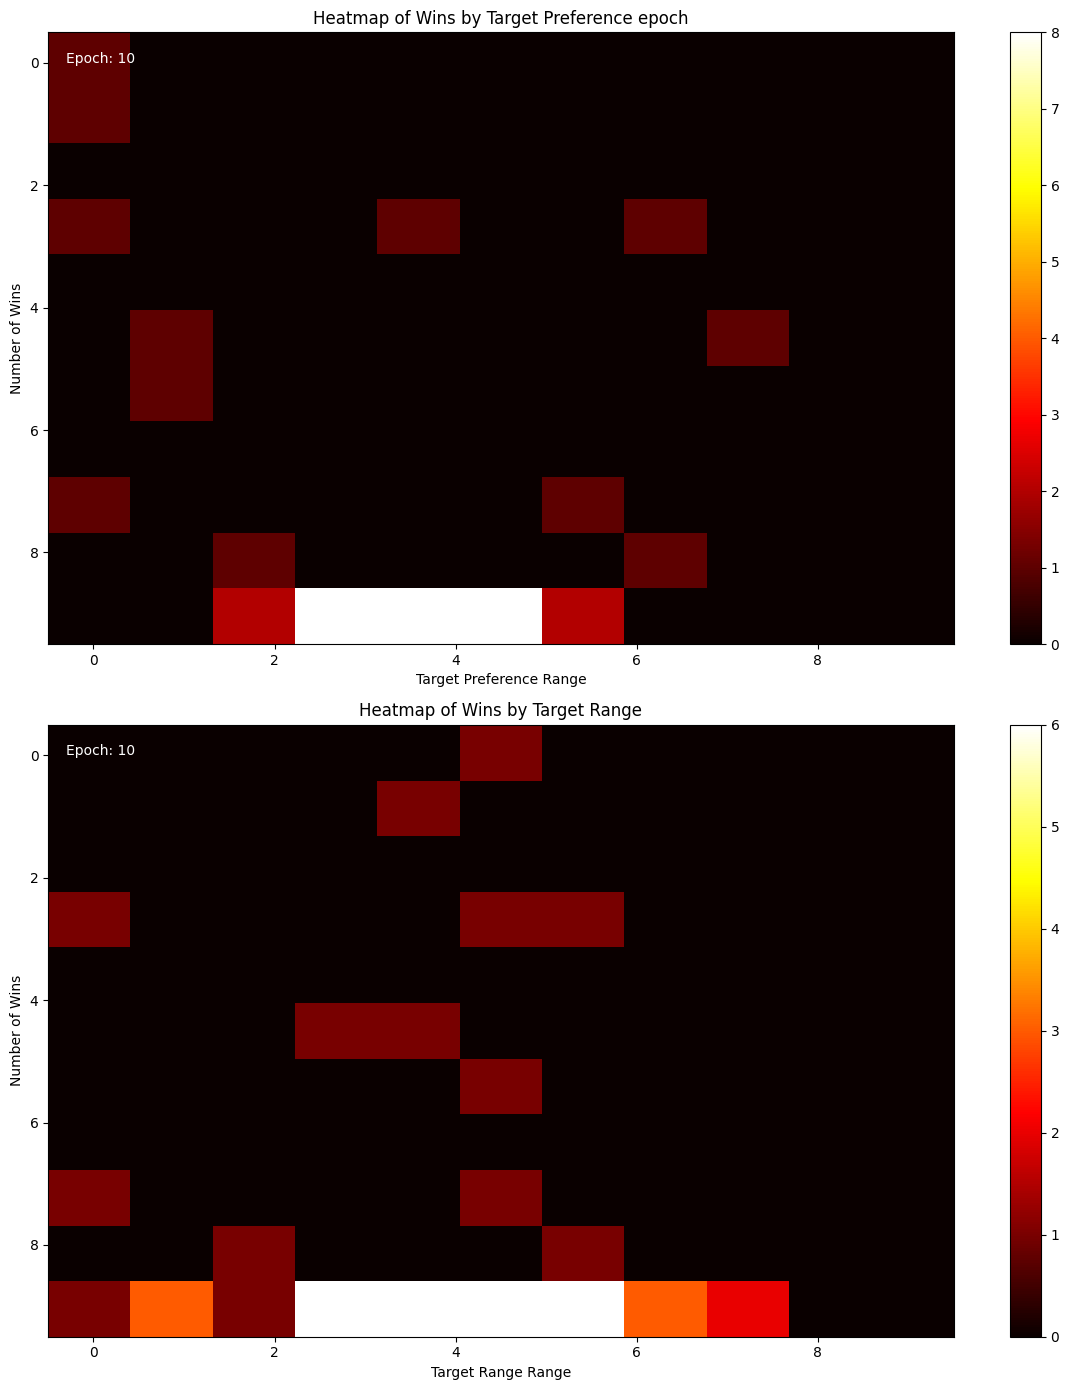

In [68]:
plot_heatmap_animation(pop_r[0:-1], num_games=10, name = "roulette")

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


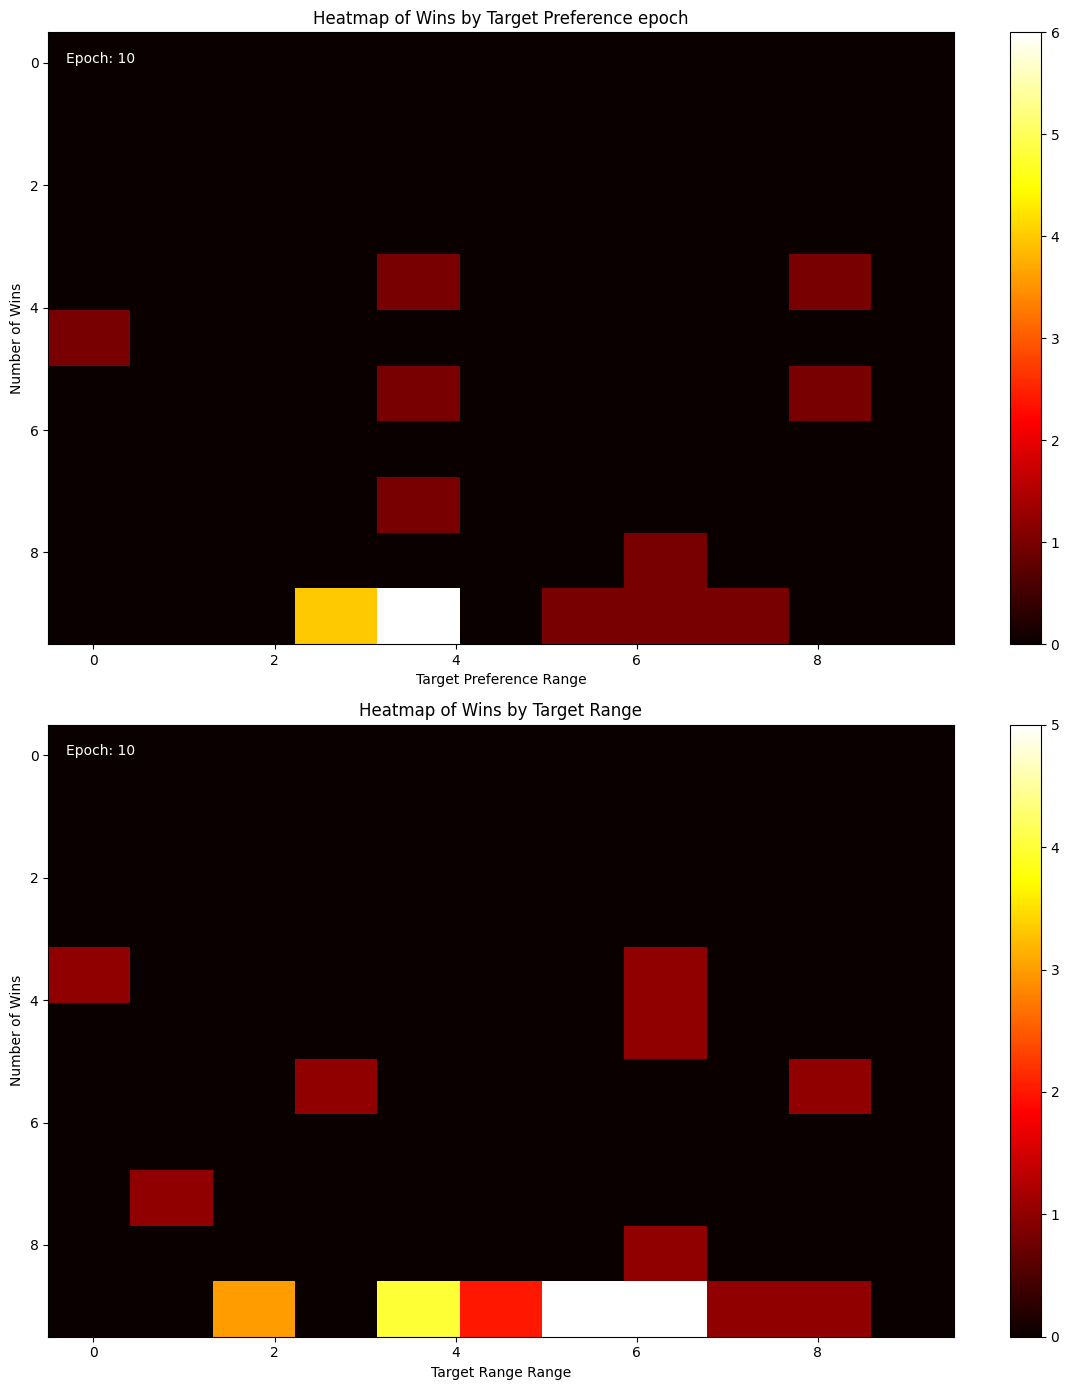

In [69]:
plot_heatmap_animation(pop_t[0:-1], num_games=10, name = "tournament")

\![SegmentLocal](animation.gif "segment")

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


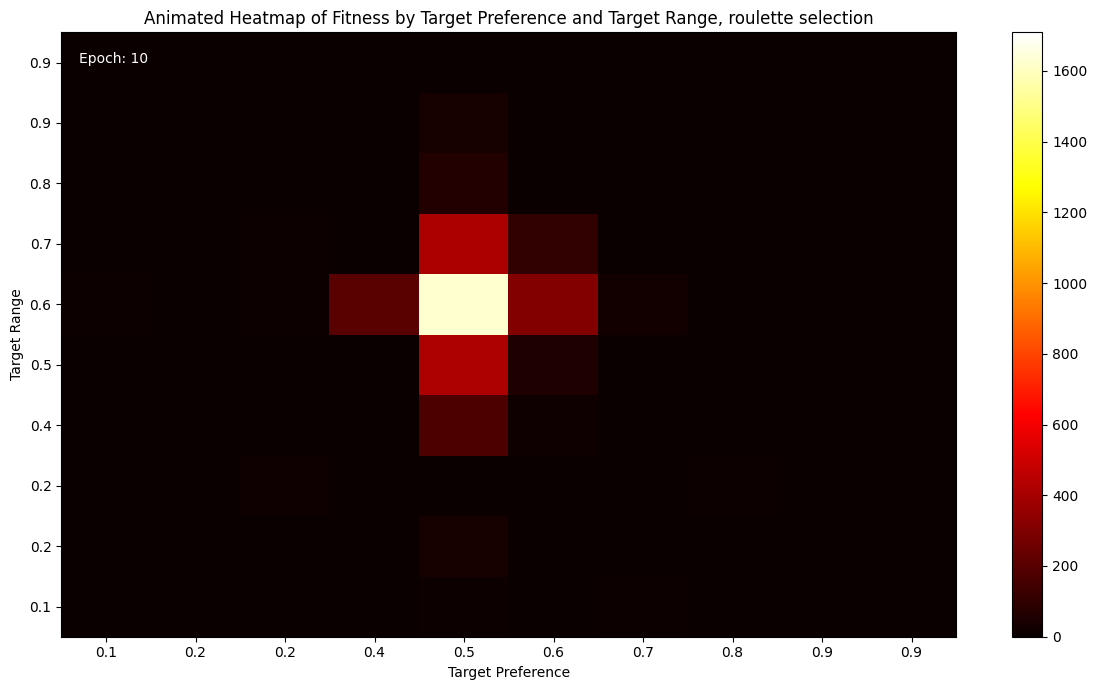

In [70]:
plot_heatmap_animation_single(pop_r[0:-1], name="roulette")

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


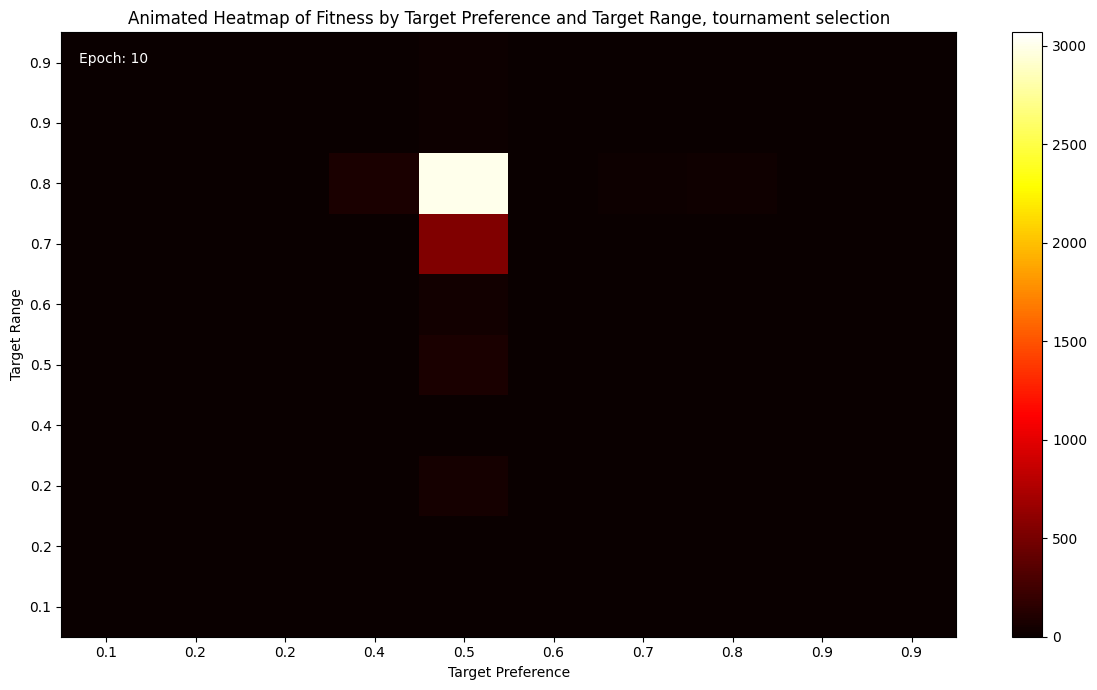

In [71]:
plot_heatmap_animation_single(pop_t[0:-1], name="tournament")

\![SegmentLocal](animation_single.gif "segment")

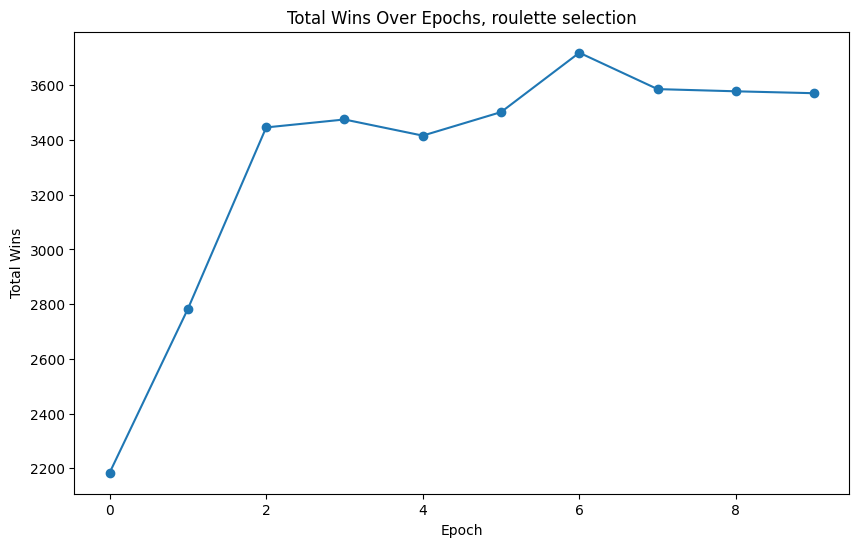

In [72]:
plot_wins_over_epochs(pop_r[0:-1], name = "roulette")

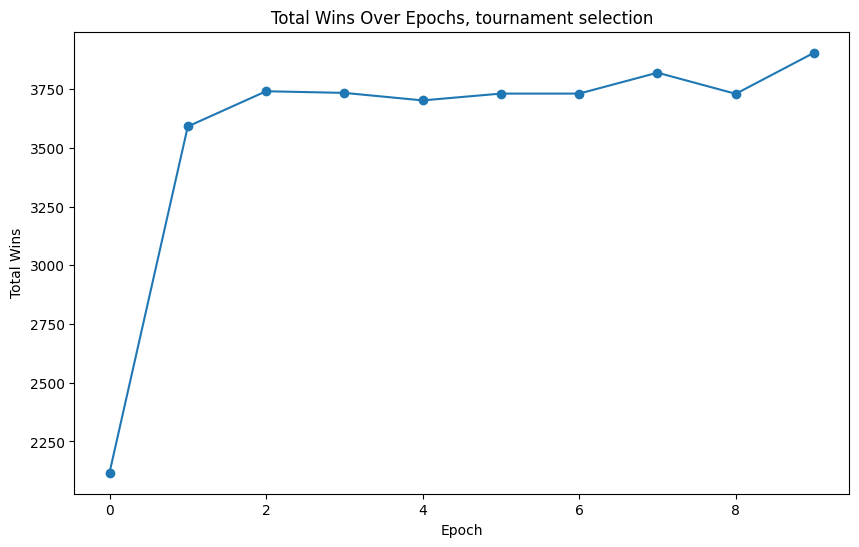

In [73]:
plot_wins_over_epochs(pop_t[0:-1], name = "tournament")